In [4]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from utils import dref_dataframe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("colorblind")

buddy = Path("write/latest-bu")
llfree = Path("write/latest-ll")


# Bare Metal

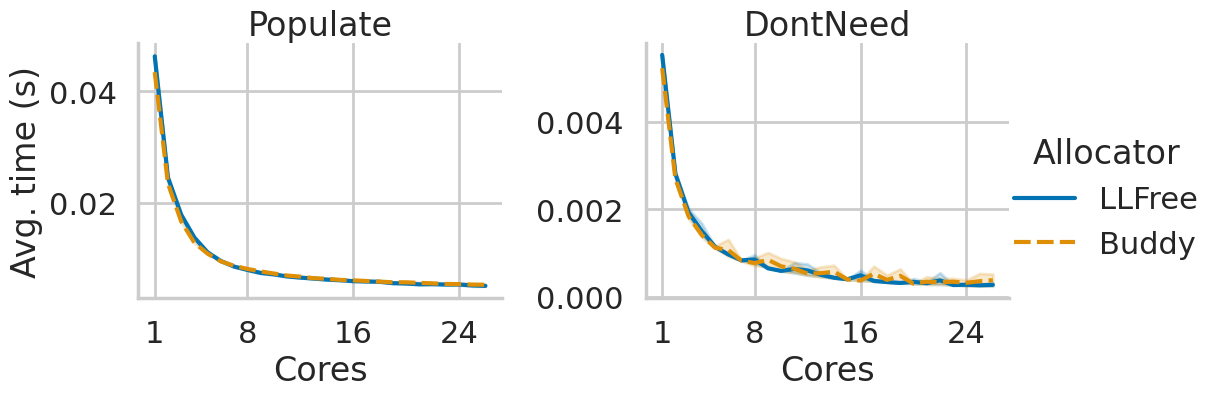

In [5]:
buddy_d = pd.read_csv(buddy / "out.csv")
buddy_d["alloc"] = "Buddy"
llfree_d = pd.read_csv(llfree / "out.csv")
llfree_d["alloc"] = "LLFree"


pgd = pd.concat([buddy_d, llfree_d], ignore_index=True)
pgd["cores"] = pgd["x"]
pgd = pgd[["cores", "alloc", "aavg", "favg", "iteration"]].melt(
    id_vars=["cores", "alloc", "iteration"],
    value_vars=["aavg", "favg"], value_name="time", var_name="operation")
pgd["operation"].replace({
    "aavg": "Populate",
    "favg": "DontNeed",
}, inplace=True)
order = ["LLFree", "Buddy"]
pgd["time"] /= 1000_000
g = sns.FacetGrid(data=pgd, col="operation", height=4.5, aspect=1.2, sharey=False)
g.map_dataframe(sns.lineplot, x="cores", y="time", style="alloc", hue="alloc",
                style_order=order, hue_order=order)
# g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
#                 col="operation", col_wrap=2, style="alloc", hue="alloc",
#                 style_order=order, hue_order=order)
g.set(xticks=[1, 8, 16, 24])
# g.set(ylim=(0, 35000))
g.add_legend(title="Allocator")
g.set(ylabel="Avg. time (s)")
g.set(xlabel="Cores")
g.set_titles("{col_name}")
g.axes_dict["DontNeed"].set(ylabel=None)
g.savefig("out/write.pdf")

dref_dataframe("write", Path("out"), ["alloc", "cores", "operation"],
               pgd[["alloc", "cores", "operation", "time"]])


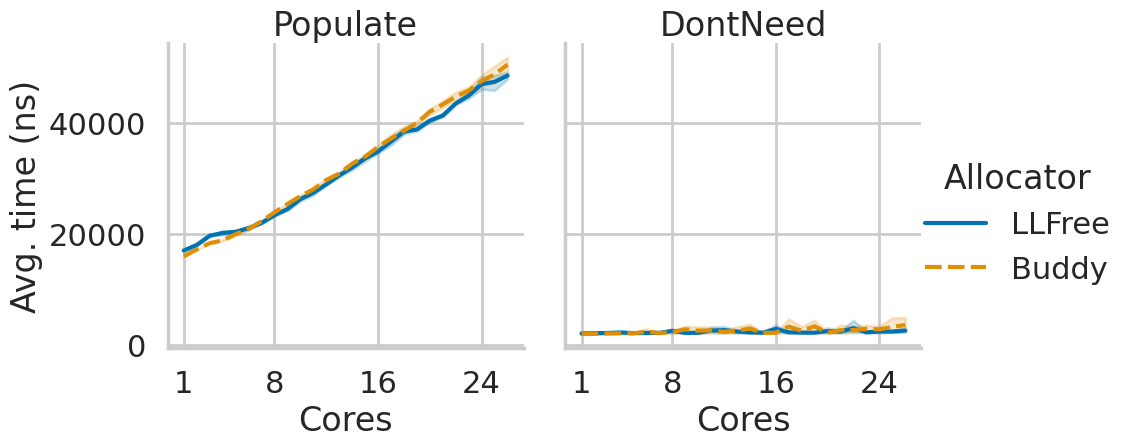

In [6]:
# Time per page access
buddy_d = pd.read_csv(buddy / "out.csv")
buddy_d["alloc"] = "Buddy"
llfree_d = pd.read_csv(llfree / "out.csv")
llfree_d["alloc"] = "LLFree"


pgd = pd.concat([buddy_d, llfree_d], ignore_index=True)
pgd["cores"] = pgd["x"]
pgd = pgd[["cores", "mem", "alloc", "aavg", "favg", "iteration"]].melt(
    id_vars=["cores", "mem", "alloc", "iteration"],
    value_vars=["aavg", "favg"], value_name="time", var_name="operation")
pgd["time"] *= 1000_0000  # ms to ns
pgd["time"] *= pgd["cores"]  # total time
pgd["time"] /= pgd["mem"] * 512 * 512  # per allocation
pgd["operation"].replace({
    "aavg": "Populate",
    "favg": "DontNeed",
}, inplace=True)
order = ["LLFree", "Buddy"]
g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
                col="operation", col_wrap=2, style="alloc", hue="alloc",
                style_order=order, hue_order=order)
g.set(xticks=[1, 8, 16, 24])
g.legend.set_title("Allocator")
g.set(ylabel="Avg. time (ns)")
g.set(xlabel="Cores")
g.set_titles("{col_name}")
